To enable GPU:
Runtime -> Change runtime type -> GPU

In [35]:
#! pip install onnxruntime
#! pip install openvino
#! pip install huggingface_hub
#! pip install git+https://github.com/parlance/ctcdecode
#! pip install pyclipper

#! git clone https://github.com/ai-forever/SEGM-model.git
#! git clone https://github.com/ai-forever/OCR-model.git
#! git clone https://github.com/ai-forever/ReadingPipeline.git

In [2]:
import sys
sys.path.append('SEGM-model/')
sys.path.append('OCR-model/')
sys.path.append('ReadingPipeline/')

import cv2
from matplotlib import pyplot as plt
import numpy as np
import json

from huggingface_hub import hf_hub_download

from ocrpipeline.predictor import PipelinePredictor
from ocrpipeline.linefinder import get_structured_text
from ocrpipeline.utils import get_image_visualization, get_line_number_visualization

In [5]:
def get_config_and_download_weights_peter(repo_id, device='cuda'):
    # download weights and configs
    pipeline_config_path = hf_hub_download(repo_id, "pipeline_config.json")
    ocr_model_path = hf_hub_download(repo_id, "ocr/ocr_model.ckpt")
    ocr_config_path = hf_hub_download(repo_id, "ocr/ocr_config.json")
    segm_model_path = hf_hub_download(repo_id, "segm/segm_model.ckpt")
    segm_config_path = hf_hub_download(repo_id, "segm/segm_config.json")

    # change paths to downloaded weights and configs in main pipeline_config
    with open(pipeline_config_path, 'r') as f:
        pipeline_config = json.load(f)

    pipeline_config['main_process']['SegmPrediction']['model_path'] = segm_model_path
    pipeline_config['main_process']['SegmPrediction']['config_path'] = segm_config_path
    pipeline_config['main_process']['SegmPrediction']['num_threads'] = 4
    pipeline_config['main_process']['SegmPrediction']['device'] = device
    pipeline_config['main_process']['SegmPrediction']['runtime'] = "Pytorch"

    pipeline_config['main_process']['OCRPrediction']['model_path'] = ocr_model_path
    pipeline_config['main_process']['OCRPrediction']['config_path'] = ocr_config_path
    pipeline_config['main_process']['OCRPrediction']['num_threads'] = 4
    pipeline_config['main_process']['OCRPrediction']['device'] = device
    pipeline_config['main_process']['OCRPrediction']['runtime'] = "Pytorch"

    # save pipeline_config
    with open(pipeline_config_path, 'w') as f:
        json.dump(pipeline_config, f)

    return pipeline_config_path

In [3]:
def get_config_and_download_weights_notebooks(repo_id, device='cpu'):
    # download weights and configs
    pipeline_config_path = hf_hub_download(repo_id, "pipeline_config.json")
    ocr_model_path = hf_hub_download(repo_id, "ocr/ocr_model.onnx")
    kenlm_path = hf_hub_download(repo_id, "ocr/kenlm_corpus.arpa")
    ocr_config_path = hf_hub_download(repo_id, "ocr/ocr_config.json")
    segm_model_path = hf_hub_download(repo_id, "segm/segm_model.onnx")
    segm_config_path = hf_hub_download(repo_id, "segm/segm_config.json")

    # change paths to downloaded weights and configs in main pipeline_config
    with open(pipeline_config_path, 'r') as f:
        pipeline_config = json.load(f)
    pipeline_config['main_process']['SegmPrediction']['model_path'] = segm_model_path
    pipeline_config['main_process']['SegmPrediction']['config_path'] = segm_config_path
    pipeline_config['main_process']['SegmPrediction']['num_threads'] = 2
    pipeline_config['main_process']['SegmPrediction']['device'] = device
    pipeline_config['main_process']['SegmPrediction']['runtime'] = "OpenVino"

    pipeline_config['main_process']['OCRPrediction']['model_path'] = ocr_model_path
    pipeline_config['main_process']['OCRPrediction']['lm_path'] = kenlm_path
    pipeline_config['main_process']['OCRPrediction']['config_path'] = ocr_config_path
    pipeline_config['main_process']['OCRPrediction']['num_threads'] = 2
    pipeline_config['main_process']['OCRPrediction']['device'] = device
    pipeline_config['main_process']['OCRPrediction']['runtime'] = "OpenVino"

    # save pipeline_config
    with open(pipeline_config_path, 'w') as f:
        json.dump(pipeline_config, f)

    return pipeline_config_path

## Download weights and initialize the pipeline

In [ ]:
PIPELINE_CONFIG_PATH = get_config_and_download_weights_peter("sberbank-ai/ReadingPipeline-Peter")

predictor = PipelinePredictor(pipeline_config_path=PIPELINE_CONFIG_PATH)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
PIPELINE_CONFIG_PATH_note = get_config_and_download_weights_notebooks("sberbank-ai/ReadingPipeline-notebooks")

predictor_note = PipelinePredictor(pipeline_config_path=PIPELINE_CONFIG_PATH_note)

## Download and show the demo image

For Peter:

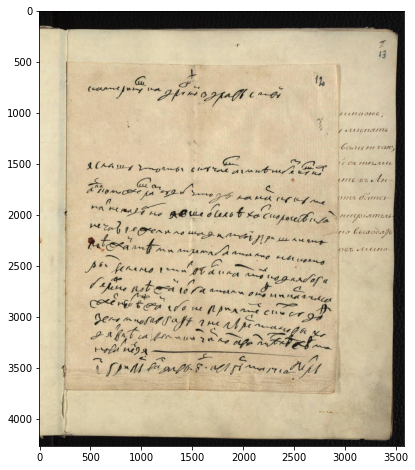

In [ ]:
img_path = hf_hub_download("sberbank-ai/ReadingPipeline-Peter", "0_0.jpg")

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.show()

In [ ]:
#!wget -nc https://www.dropbox.com/s/qw37tbe0xlcjtpw/images.zip?dl=0 -O peter.zip
# if the link does not work, you can download the dataset manually from https://disk.yandex.ru/d/nuyCNaDrE1Bq0w
#!unzip -n peter.zip

## Predict

In [ ]:
image = cv2.imread(img_path)
rotated_image, pred_data = predictor(image)

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
structured_text = get_structured_text(pred_data, ['shrinked_text'])

result_text = [' '.join(line_text) for page_text in structured_text
                for line_text in page_text]

for line in result_text:
    print(line)

+
катеринушка друг мой здравъствуй
я слышу что ты скучаеш а i мнѣ не безкушно ж
аднако можеш разсудит что дѣла на скуку ме
нят не надобно я еше отсель ѣхат скоро себѣ к вам
не чаю i ежели лошади твоi пришли то
поѣжай тѣми тремя баталионы кото
рым велено iтит въ анклам толко для бога
бережно поѣжай i от баталионоф ни на ста са
жен не отѣжжай iбо неприятелских судоф
зело многа в гафѣ i непърестано выхо
дят в лѣса великим числом а вам тѣх лѣсоф ми
новат нелзя
iз грипъсвалда въ 8 д авъгуста 1712 петръ


In [ ]:
image = cv2.imread('/content/images/0_6.jpg')

rotated_image, pred_data = predictor(image)

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


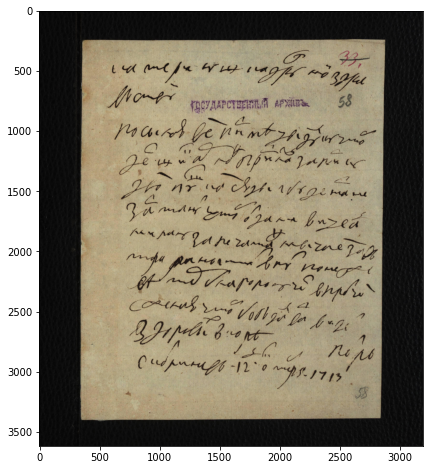

In [ ]:
image = cv2.imread('/content/images/12_11.jpg')
rotated_image, pred_data = predictor(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.show()

In [ ]:
structured_text = get_structured_text(pred_data, ['shrinked_text'])
for page_text in structured_text:
    for line_text in page_text:
        if line_text:
            print(' '.join(line_text))
    print('\n')

катеринушка друг мой здра
въствуй
посылаю в ем писмѣ цыдулку чтоб
деншик арлоф прислал записку
двом пушкам сюды i буде нас не
застанут чтоб отдали вице ад
миралу запечатаф мы чаем завъ
тора рано iтит в пут понеже
вѣтер благополучен в протчем
желаю чтоб богъ дал вас видет
здоровых вкорѣ
петръ
с котлина въ 12 д октебря 1713




For schook_notebooks_RU:

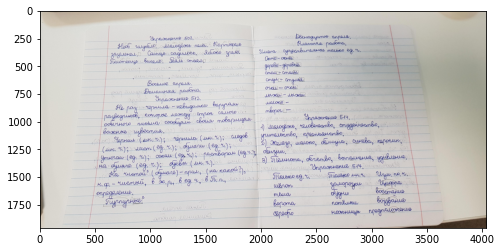

In [ ]:
img_path = hf_hub_download("sberbank-ai/ReadingPipeline-notebooks", "0_0.jpg")

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.show()

In [ ]:
image = cv2.imread(img_path)
rotated_image, pred_data = predictor_note(image)

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
structured_text = get_structured_text(pred_data, ['shrinked_text'])

result_text = [' '.join(line_text) for page_text in structured_text
                for line_text in page_text]

for line in result_text:
    print(line)

Упражнение 503.
Небо голубело. Молодёжь пела. Картофель
зазеленел. Солнце садилось. Яблоко зрело.
Полотенце висело. Рояль стоял.
Восьмое апреля.
Домашняя работа.
Упражнение 512.
Не раз чернила невидимки выручали
разведчиков, которые между строк самого
обычного письма сообщали своим товарищам.
важные известия.
Чернил (мн. ч.); чернила (мн. ч.); следов
(мн. ч.); лист (ед. ч.); бумаги (ед. ч.);
утюгом (ед. ч.); соком (ед. ч.); раствором, (ед. ч.);
на бумаге (ед. ч.); буквы (мн. ч.).
На чистой (бумаге)- прил., (на какой?),
н.ф. чистый, в ж.р., в ед. ч., в П.
определение.
Пурпурные.
Двенадцатое апреля.
Классная работа.
Имена существительные только ед. ч.
Окно окна
дерево- деревья
стол столы
стул- стулья.
очки очки
лыжи лыжи
молоко-
творог
Упражнение 514.
1) Молодёжь, человечество, студенчество,
учительство, крестьянство.
2 Железо, молоко, белизна, синева, керосин,
бензин.
3) Темнота, бегство, выполнение, удивление.
Упражнение 517.
Изм. по.ч.
Только мн. ч
Толькоед. ч
Цифра
заморозки,
шёпот
в

In [ ]:
ls

data/       LICENSE   ocrpipeline/  requirements.txt  setup.py
Dockerfile  Makefile  README.md     scripts/


In [ ]:
cd ReadingPipeline/

/content/ReadingPipeline


###Evaluation pretrained model on train and val by calculating 
CER (character error rate), WER (word error rate), ACC (string accuracy)

In [4]:
import cv2
import json
from tqdm import tqdm
import os

from ocrpipeline.predictor import PipelinePredictor
from ocrpipeline.utils import get_image_visualization

In [ ]:
'/content/ReadingPipeline/scripts/pipeline_config.json'

### on Peter:

In [ ]:
#!wget -nc https://www.dropbox.com/s/qw37tbe0xlcjtpw/images.zip?dl=0 -O peter.zip
# if the link does not work, you can download the dataset manually from https://disk.yandex.ru/d/nuyCNaDrE1Bq0w
#!unzip -n peter.zip

In [ ]:
# Path to json with segmentation dataset annotation in COCO format
DATA_JSON_PATH = '/content/annotations_val.json'

# Path to folder with evaluation images
IMAGE_ROOT = '/content/ReadingPipeline/images'

# Folder to save prediction json (one for each image)
SAVE_FOLDER = '/content/save'

In [ ]:
PIPELINE_CONFIG_PATH = get_config_and_download_weights_peter("sberbank-ai/ReadingPipeline-Peter")

predictor = PipelinePredictor(pipeline_config_path=PIPELINE_CONFIG_PATH)

In [ ]:
#predictor = PipelinePredictor(pipeline_config_path=PIPELINE_CONFIG_PATH)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
os.makedirs(SAVE_FOLDER, exist_ok=True)

with open(DATA_JSON_PATH, 'r') as f:
    data = json.load(f)

for data_img in tqdm(data['images']):
    img_name = data_img['file_name']
    image = cv2.imread(os.path.join(IMAGE_ROOT, img_name))

    rotated_image, pred_data = predictor(image)

    pred_json_name = os.path.splitext(img_name)[0] + '.json'
    pred_json_path = os.path.join(SAVE_FOLDER, pred_json_name)
    with open(pred_json_path, 'w') as f:
        json.dump(pred_data, f)

In [ ]:
['pupil_text', 'pupil_comment', 'teacher_comment']
['shrinked_pupil_text', 'shrinked_comments']

In [ ]:
['shrinked_text', 'bordered_text']

In [ ]:
!python evaluate.py \
  --annotation_json_path {DATA_JSON_PATH} \
  --ann_class_names text \
  --pred_class_names shrinked_text \
  --pred_jsons_dir {SAVE_FOLDER}

На вале:

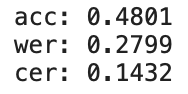

На трейне:

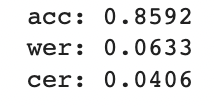

In [ ]:
!python evaluate.py \
  --annotation_json_path {DATA_JSON_PATH} \
  --ann_class_names text \
  --pred_class_names shrinked_text \
  --pred_jsons_dir {SAVE_FOLDER}

### on school_notebook_RU:

In [6]:
#!wget -nc https://www.dropbox.com/s/wcjqtd2rck69vuq/images-2.zip?dl=0 -O notesRU.zip
#!unzip -n notesRU.zip

In [7]:
# Path to json with segmentation dataset annotation in COCO format
DATA_JSON_PATH = '/content/annotations_val-2.json'

# Path to folder with evaluation images
IMAGE_ROOT = '/content/images'

# Folder to save prediction json (one for each image)
SAVE_FOLDER = '/content/save_notebooksRU'

In [8]:
PIPELINE_CONFIG_PATH_note = get_config_and_download_weights_notebooks("sberbank-ai/ReadingPipeline-notebooks")

predictor = PipelinePredictor(pipeline_config_path=PIPELINE_CONFIG_PATH_note)

In [ ]:
os.makedirs(SAVE_FOLDER, exist_ok=True)

with open(DATA_JSON_PATH, 'r') as f:
    data = json.load(f)

for data_img in tqdm(data['images']):
    img_name = data_img['file_name']
    image = cv2.imread(os.path.join(IMAGE_ROOT, img_name))

    rotated_image, pred_data = predictor(image)

    pred_json_name = os.path.splitext(img_name)[0] + '.json'
    pred_json_path = os.path.join(SAVE_FOLDER, pred_json_name)
    with open(pred_json_path, 'w') as f:
        json.dump(pred_data, f)

In [ ]:
!python evaluate.py \
  --annotation_json_path {DATA_JSON_PATH} \
  --ann_class_names pupil_text pupil_comment teacher_comment \
  --pred_class_names shrinked_text \
  --pred_jsons_dir {SAVE_FOLDER}

На вале для SchoolNotebooksRU:

---



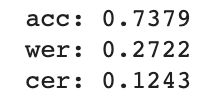